In [1]:
import anndata as ad
import matplotlib.pyplot as plt
# import rapids_singlecell as rsc
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os

main_path = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning'
import warnings
warnings.filterwarnings("ignore")

sys.path.append(main_path)
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *

sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries')
from data_processing import *

In [2]:
dataset            = 'LATTICeA_5x'

meta_field         = None
matching_field     = 'samples'
resolution         = 2.5
fold_number        = 2
groupby            = 'leiden_%s' % resolution
meta_folder        = 'rapids_2p5m'
folds_pickle       = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/utilities/fold_creation/lattice_5x_folds_noNaN.pkl'
additional_as_fold = False
h5_complete_path   = '/mnt/cephfs/home/users/krakovic/sharedscratch/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/hdf5_LATTICeA_5x_he_complete_surv_sex_filtered.h5'
h5_additional_path = None
Transform          = False

main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
figure_path       = os.path.join(main_cluster_path, 'leiden_%s_fold%s' % (str(resolution).replace('.','p'),fold_number))
figure_path       = os.path.join(figure_path,       'figures')
if not os.path.isdir(figure_path):
    os.makedirs(figure_path)

folds = load_existing_split(folds_pickle)
fold = folds[fold_number]

In [3]:
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

if os.path.isfile(h5ad_path.replace('.h5ad', '_paga_41.h5ad')):
    adata_train = ad.read_h5ad(h5ad_path.replace('.h5ad', '_paga_41.h5ad'))
else:
    rsc.tl.umap(adata_train, init_pos="spectral", neighbors_key='nn_leiden')
    adata_train.write(h5ad_path.replace('.h5ad', '_paga_41.h5ad'))

### UMAP - Leiden clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


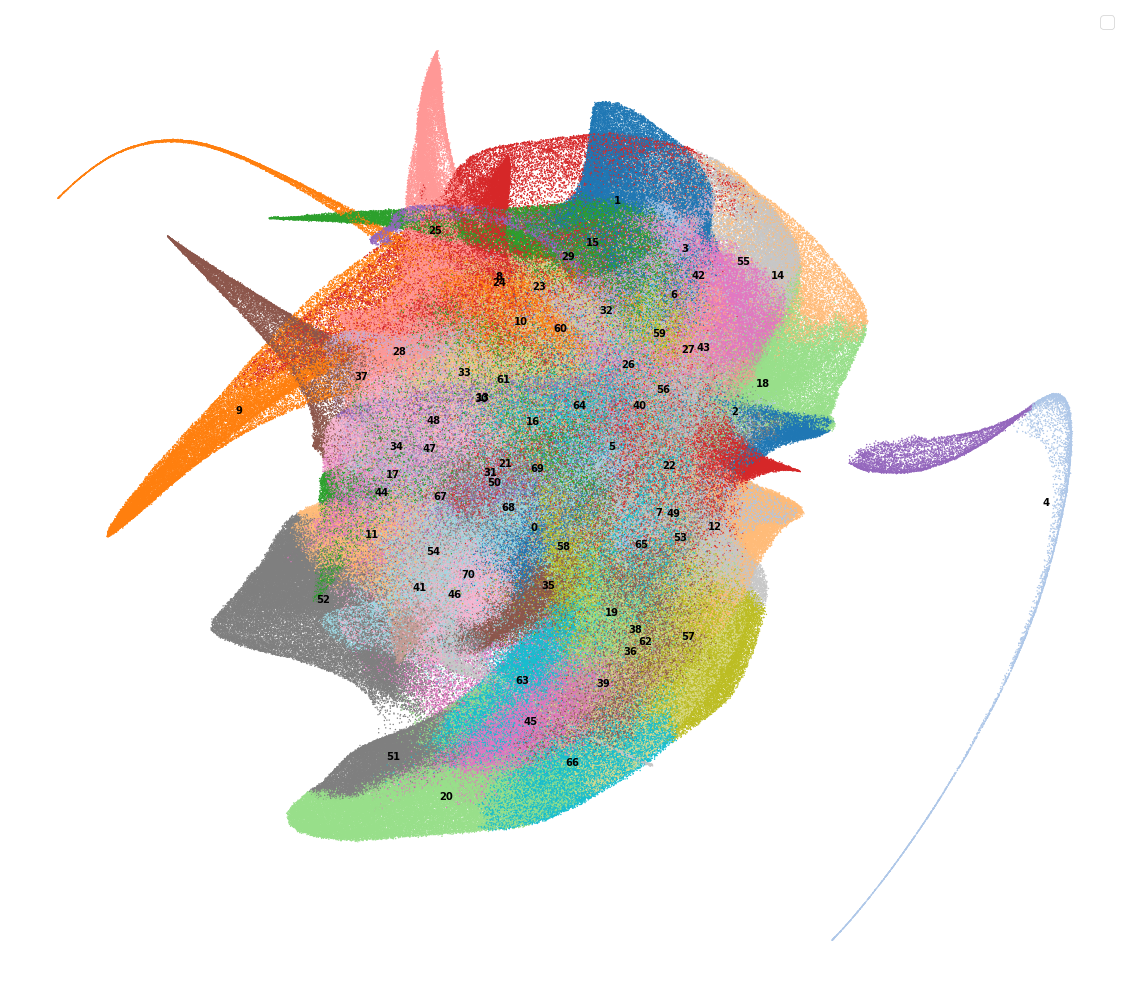

In [4]:
sns.set_context('paper', font_scale=2.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))
sc.pl.umap(adata_train, color=groupby, show=False, ax=ax, size=8, legend_loc='on data', palette='tab20')
ax.set_title(None)
ax.legend(loc='best', markerscale=1)

plt.axis('off')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_all.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

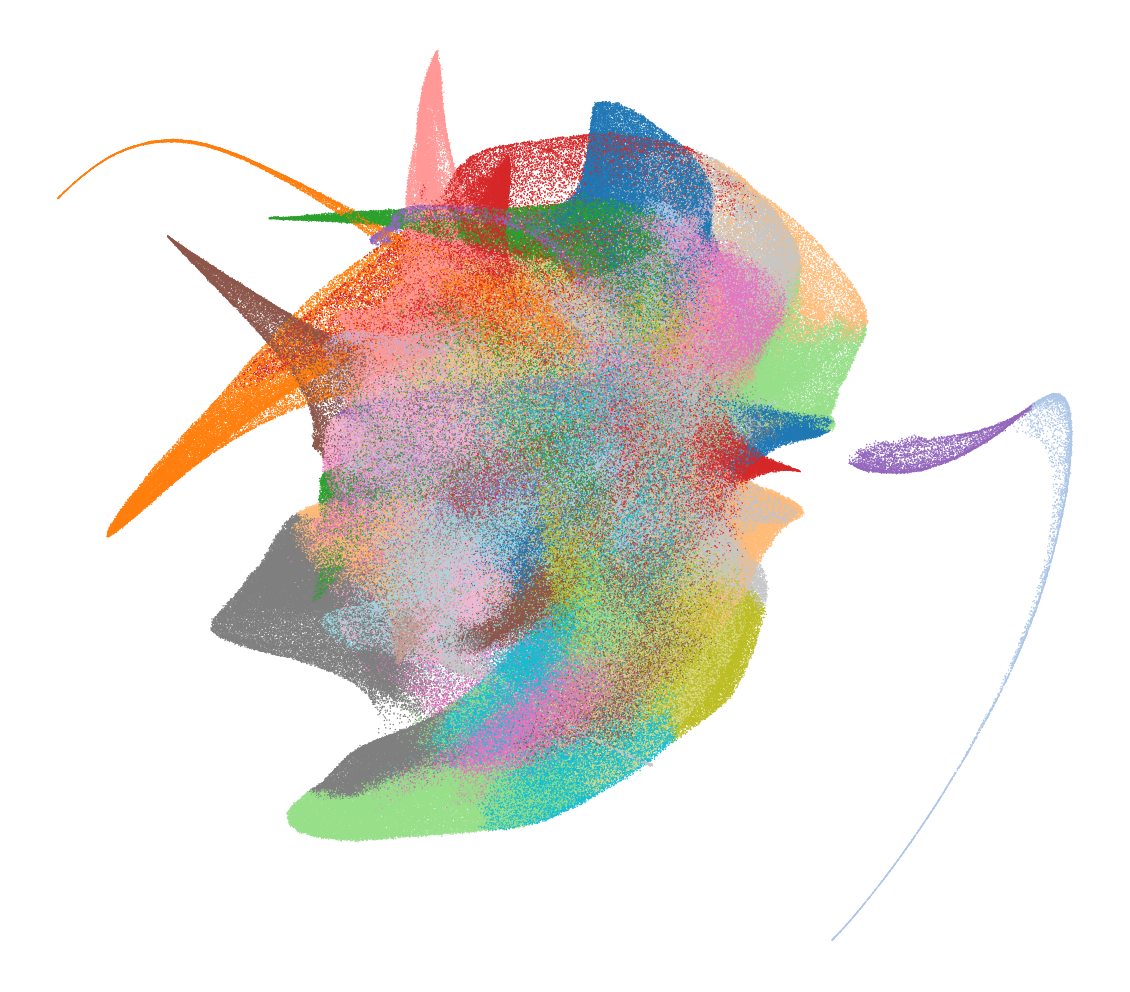

In [5]:
sns.set_context('paper', font_scale=2.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))
sc.pl.umap(adata_train, color=groupby, show=False, ax=ax, size=8, legend_loc=None, palette='tab20')
ax.set_title(None)

plt.axis('off')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_all_no_labels.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_all_no_labels.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Consensus annotations

In [6]:
annotations = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/base/consensus_frame_JLQ_DD_KR.csv', index_col=0)
annotations['feature'] = annotations['feature'].apply(lambda x: x.capitalize())
annotations = annotations.fillna(0)
annotations['feature_category'] = 'Normal/non-neoplastic'
annotations['feature_category'] = annotations.apply(lambda row: 'Malignant' if row['malignant'] == 1 else row['feature_category'], axis=1)
annotations['feature_category'] = annotations.apply(lambda row: 'Stroma' if row['feature'] in ['Collagenosis', 'Elastosis', 'Lymphocytic Stroma', 'Other'] else row['feature_category'], axis=1)
annotations['feature_category'] = annotations.apply(lambda row: 'Necrosis' if row['feature'] == 'Necrosis' else row['feature_category'], axis=1)
annotations['stroma_epi_ratio'] = annotations['stroma_epi_ratio'].replace({1:'More epithelium', 2:'Roughly equal', 3:'More stroma'})
annotations['stroma_cellularity'] = annotations['stroma_cellularity'].replace({1:'Low', 2:'Moderate', 3:'High'})
annotations['inflammation'] = annotations['inflammation'].replace({1:'Low', 2:'Moderate', 3:'High'})


annotations

cluster  malignant                           feature inflammation  \
0         0          1                            Acinar     Moderate   
1         1          0                      Collagenosis          Low   
2         2          0                             Other     Moderate   
3         3          0                      Collagenosis          Low   
4         4          0                         Cartilage          Low   
..      ...        ...                               ...          ...   
66       66          0           Normal/near-normal lung          Low   
67       67          1                            Acinar         High   
68       68          1                            Acinar     Moderate   
69       69          1                            Acinar     Moderate   
70       70          0  Non-neoplastic pathological lung     Moderate   

    necrosis stroma_epi_ratio stroma_cellularity  purity  description  \
0        1.0    Roughly equal           Moderate     3.0          0.0   
1        1.0              0.0                0.0     3.0          0.0   
2        1.0              0.0                0.0     3.0          0.0   
3        1.0              0.0                0.0     3.0          0.0   
4        1.0              0.0                0.0     3.0          0.0   
..       ...              ...                ...     ...          ...   
66       1.0              0.0                0.0     3.0          0.0   
67       1.0    Roughly equal           Moderate     3.0          0.0   
68       1.0    Roughly equal           Moderate     3.0          0.0   
69       1.0      More stroma           Moderate     3.0          0.0   
70       1.0              0.0                0.0     3.0          0.0   

      free text       feature_category  
0             0              Malignant  
1             0                 Stroma  
2   Anthracosis                 Stroma  
3             0                 Stroma  
4             0  Normal/non-neoplastic  
..          ...                    ...  
66            0  Normal/non-neoplastic  
67            0              Malignant  
68            0              Malignant  
69            0              Malignant  
70            0  Normal/non-neoplastic  

[71 rows x 11 columns]

In [7]:
adata_train.obs['consensus_feature'] = adata_train.obs['leiden_2.5'].apply(lambda x: annotations[annotations['cluster'].astype(str) == x]['feature'].values[0])
print('Patterns:', adata_train.obs['consensus_feature'].unique())

adata_train.obs['contain_tumour'] = adata_train.obs['leiden_2.5'].apply(lambda x: annotations[annotations['cluster'].astype(str) == x]['malignant'].values[0])
print('Tumoural:', adata_train.obs['contain_tumour'].unique())

adata_train.obs['stroma_epi_ratio'] = adata_train.obs['leiden_2.5'].apply(lambda x: str(annotations[annotations['cluster'].astype(str) == x]['stroma_epi_ratio'].values[0]))
adata_train.obs['stroma_epi_ratio'] = adata_train.obs['stroma_epi_ratio'].astype(str)
print('Stroma:epithelium ratio:', adata_train.obs['stroma_epi_ratio'].unique())

adata_train.obs['stroma_cellularity'] = adata_train.obs['leiden_2.5'].apply(lambda x: str(annotations[annotations['cluster'].astype(str) == x]['stroma_cellularity'].values[0]))
adata_train.obs['stroma_cellularity'] = adata_train.obs['stroma_cellularity'].astype(str)
print('Stromal cellularity:', adata_train.obs['stroma_cellularity'].unique())

adata_train.obs['inflammation'] = adata_train.obs['leiden_2.5'].apply(lambda x: str(annotations[annotations['cluster'].astype(str) == x]['inflammation'].values[0]))
adata_train.obs['inflammation'] = adata_train.obs['inflammation'].astype(str)
print('Inflammation:', adata_train.obs['inflammation'].unique())

adata_train.obs['feature_category'] = adata_train.obs['leiden_2.5'].apply(lambda x: annotations[annotations['cluster'].astype(str) == x]['feature_category'].values[0])
print('Feature categories:', adata_train.obs['feature_category'].unique())

Patterns: ['Normal/near-normal lung' 'Collagenosis' 'Lymphocytic stroma'
 'Cribriform' 'Non-neoplastic pathological lung' 'Solid' 'Elastosis'
 'Acinar' 'Necrosis' 'Lepidic' 'Papillary' 'Airways'
 'Papillary/micropapillary' 'Vessel (wall or lumen)' 'Other' 'Cartilage']
Tumoural: [0 1]
Stroma:epithelium ratio: ['0.0' 'More stroma' 'More epithelium' 'Roughly equal']
Stromal cellularity: ['0.0' 'Moderate' 'High' 'Low']
Inflammation: ['Moderate' 'High' 'Low']
Feature categories: ['Normal/non-neoplastic' 'Stroma' 'Malignant' 'Necrosis']


In [8]:
adata_train.obs['inflammation'] = pd.Categorical(
    adata_train.obs['inflammation'],
    categories=['Low', 'Moderate', 'High'],
    ordered=True
)


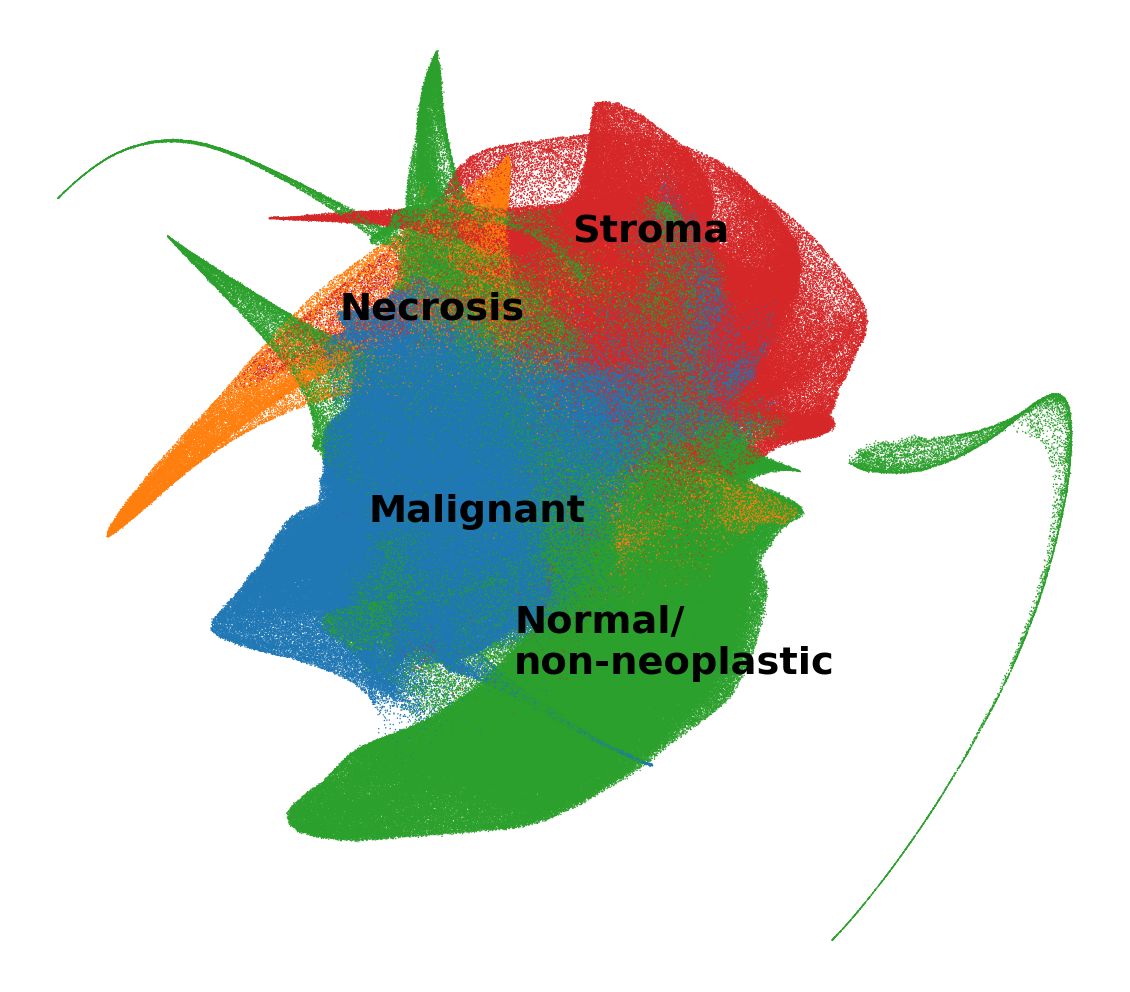

In [9]:
sns.set_context('paper', font_scale=4.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))

sc.pl.umap(adata_train, color='feature_category', show=False, ax=ax, size=8, legend_loc=None, cmap='Set2')
ax.set_title(None)

ax.text(x=-7, y=6, s='Necrosis', fontdict={'fontweight':'bold'})
ax.text(x=-1, y=-8, s='Normal/\nnon-neoplastic', fontdict={'fontweight':'bold'})
ax.text(x=-6, y=-2, s='Malignant', fontdict={'fontweight':'bold'})
ax.text(x=1, y=9, s='Stroma', fontdict={'fontweight':'bold'})

plt.axis('off')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_feature_category_tum_stroma_font4.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

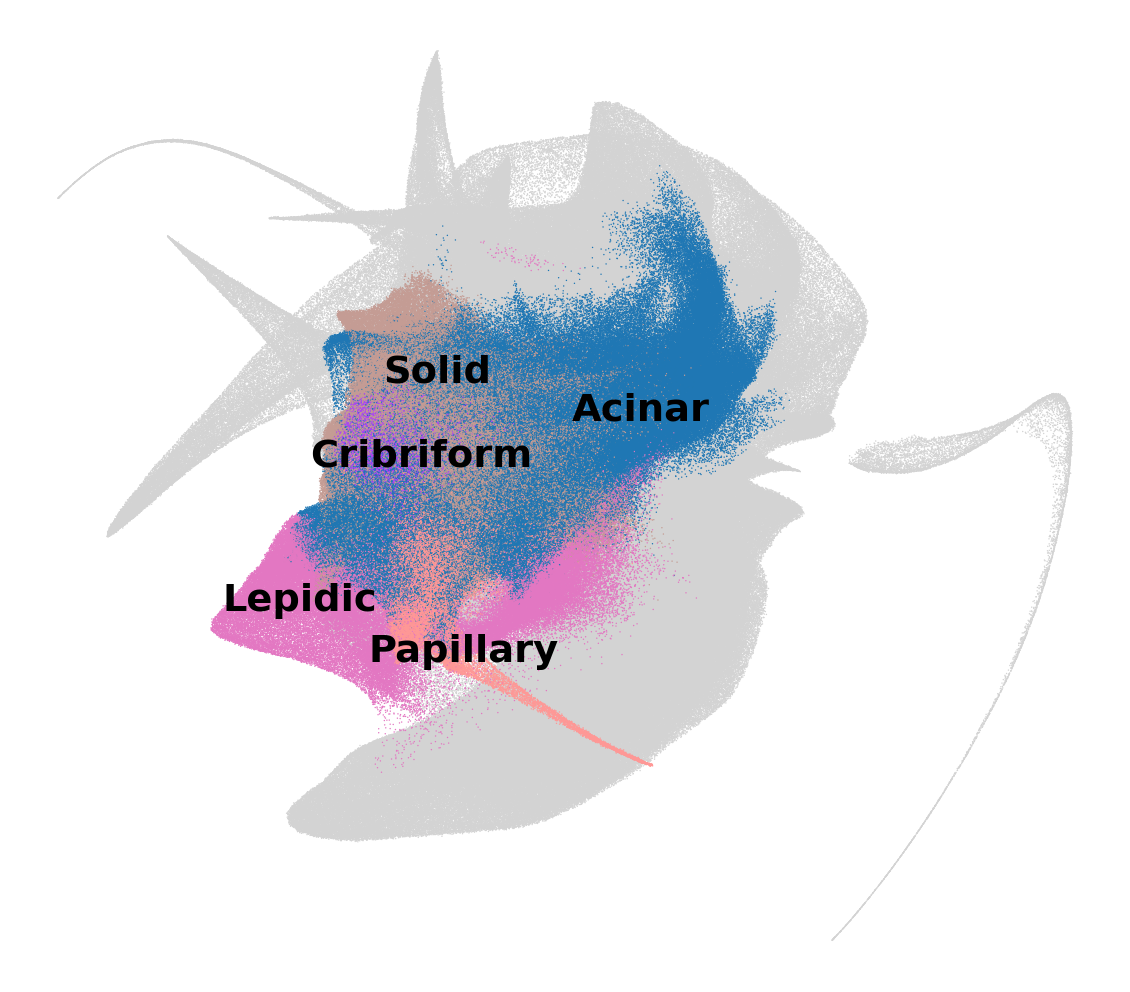

In [13]:
sns.set_context('paper', font_scale=4.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))

sc.pl.umap(adata_train, color='consensus_feature', show=False, ax=ax, size=8, legend_loc=None, cmap='Set2', groups=['Lepidic', 'Acinar', 'Papillary', 'Cribriform', 'Solid', 'Micropapillary'], na_in_legend=False)
ax.set_title(None)
ax.text(s='Lepidic', x=-11, y=-5.5, fontdict={'fontweight':'bold'})
ax.text(s='Papillary', x=-6.0, y=-7.5, fontdict={'fontweight':'bold'})
ax.text(s='Cribriform', x=-8, y=0.2, fontdict={'fontweight':'bold'})
ax.text(s='Solid', x=-5.5, y=3.5, fontdict={'fontweight':'bold'})
ax.text(s='Acinar', x=1.0, y=2, fontdict={'fontweight':'bold'})
plt.axis('off')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_feature_category_growth_pattern_font4.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

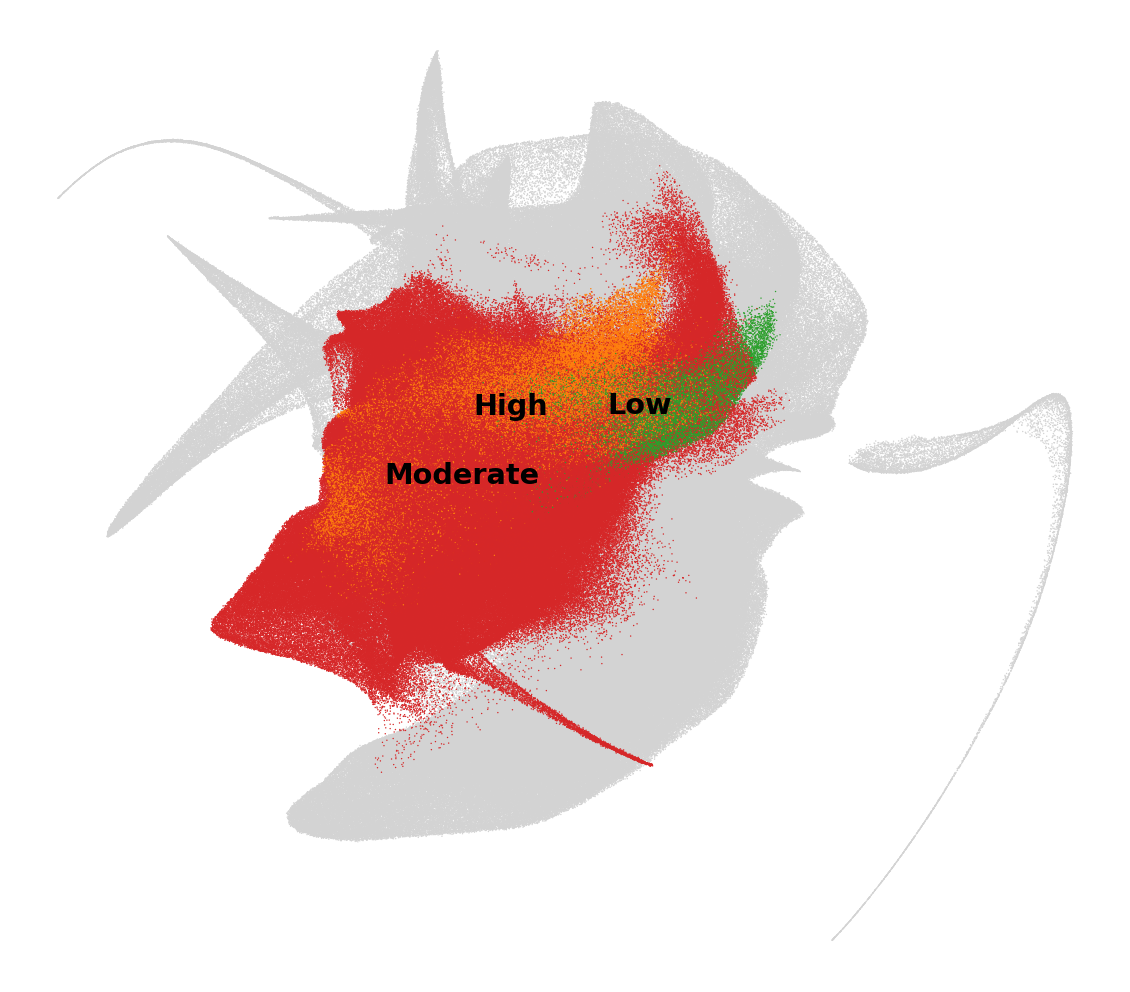

In [40]:
sns.set_context('paper', font_scale=3.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))

sc.pl.umap(adata_train, color='stroma_cellularity', show=False, ax=ax, size=8, groups=['Low', 'Moderate', 'High'], na_in_legend=False, legend_loc='on data', cmap='Set2')
ax.set_title(None)
plt.axis('off')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_feature_category_stroma_cellularity.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

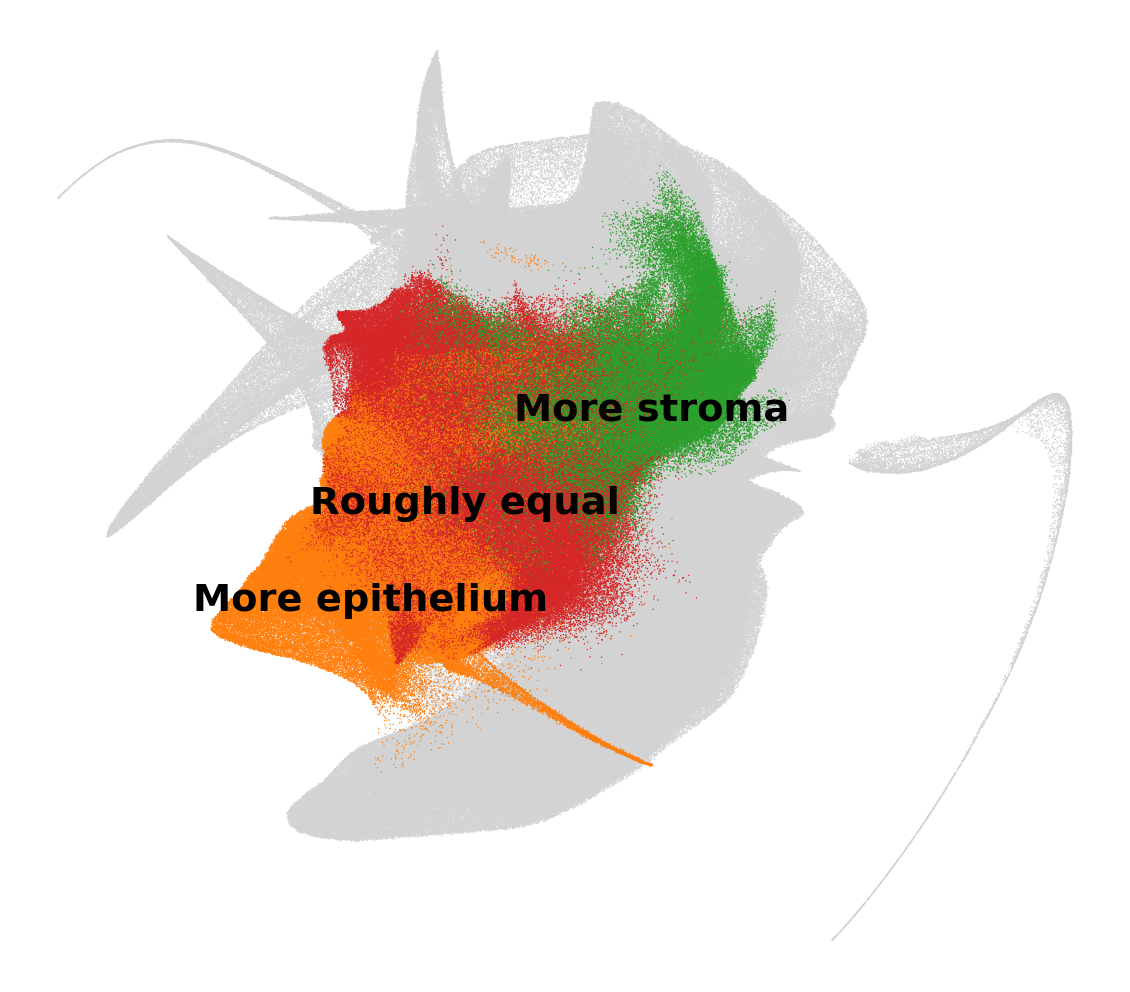

In [20]:
sns.set_context('paper', font_scale=4.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))

sc.pl.umap(adata_train, color='stroma_epi_ratio', show=False, ax=ax, size=8, groups=['More epithelium', 'Roughly equal', 'More stroma'], na_in_legend=False, legend_loc=None, cmap='Set2')
ax.set_title(None)

ax.text(s='More epithelium', x=-12, y=-5.5, fontdict={'fontweight':'bold'})
ax.text(s='Roughly equal', x=-8, y=-1.7, fontdict={'fontweight':'bold'})
ax.text(s='More stroma', x=-1.0, y=2, fontdict={'fontweight':'bold'})

plt.axis('off')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_feature_category_stroma_epi_ratio_font4.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [41]:
adata_train.obs['inflammation'] = adata_train.obs['inflammation'].replace()

3351228    2
599197     2
373088     3
4218406    2
1904584    2
          ..
2749700    1
4617051    1
956274     2
2737388    2
421760     2
Name: inflammation, Length: 2500000, dtype: int64

In [53]:
adata_train.obs['inflammation']

3351228    Moderate
599197     Moderate
373088         High
4218406    Moderate
1904584    Moderate
             ...   
2749700         Low
4617051         Low
956274     Moderate
2737388    Moderate
421760     Moderate
Name: inflammation, Length: 2500000, dtype: category
Categories (3, object): ['Low' < 'Moderate' < 'High']

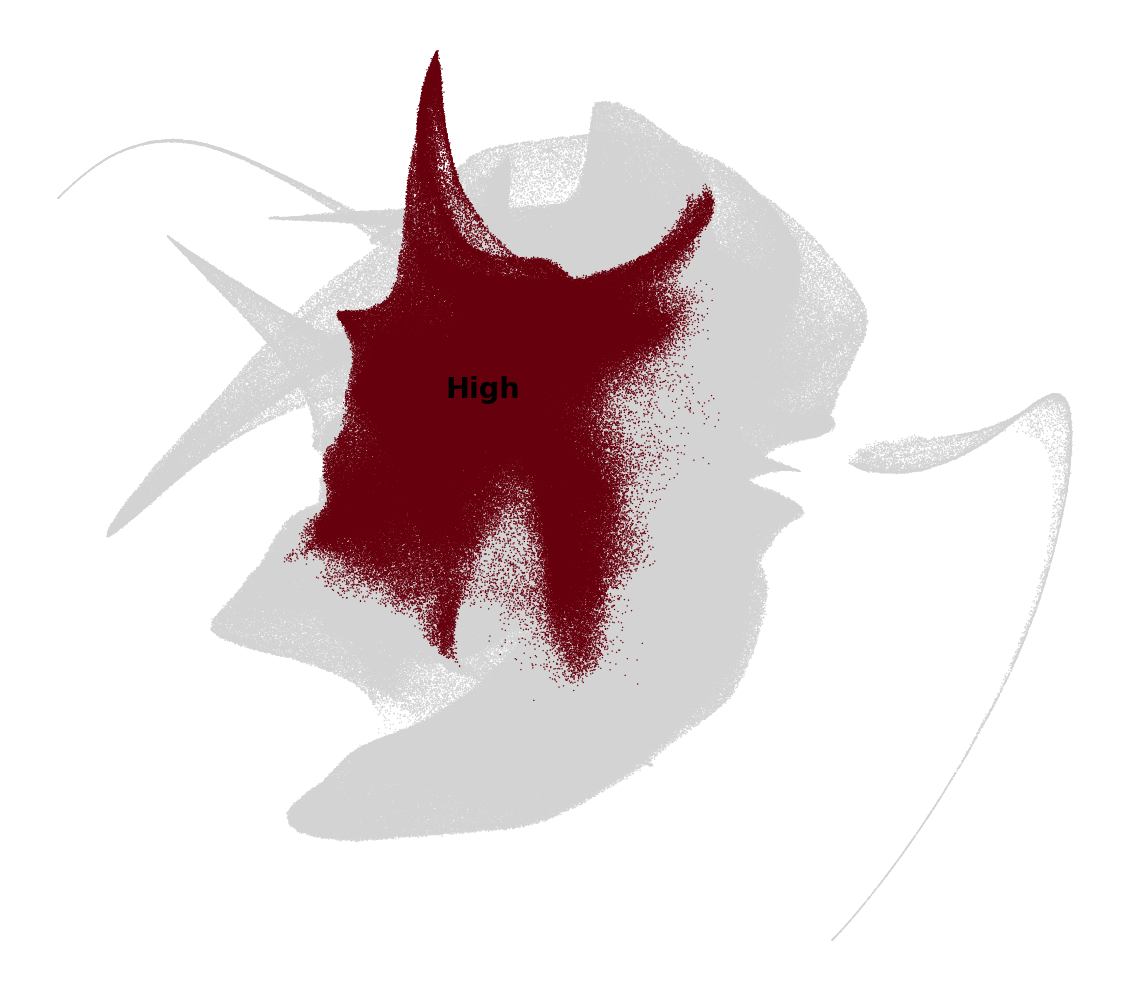

In [57]:
sns.set_context('paper', font_scale=3.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))

sc.pl.umap(adata_train, color='inflammation', show=False, ax=ax, size=8, na_in_legend=False, legend_loc='on data', palette='Reds', sort_order=True, groups=['High'])
ax.set_title(None)
plt.axis('off')
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_feature_category_stroma_epi_ratio.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Superclusters

In [4]:
cluster_annotations = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/bioclavis/data/merged_cluster_lym_log10_density_and_noise.csv')
cluster_annotations

Unnamed: 0      Supercluster     HPC     noise  robust_z_score_x  \
0            0      Hot cohesive   HPC 0  0.030344         -0.398536   
1            1     Cold cohesive  HPC 11  0.025816         -0.489230   
2            2   Hot discohesive  HPC 13  0.088962          0.775638   
3            3   Hot discohesive  HPC 16  0.215348          3.307301   
4            4     Cold cohesive  HPC 17  0.008196         -0.842181   
5            5     Cold cohesive  HPC 21  0.024876         -0.508074   
6            6  Cold discohesive  HPC 27  0.154209          2.082626   
7            7   Hot discohesive  HPC 28  0.085580          0.707910   
8            8  Cold discohesive  HPC 30  0.080967          0.615499   
9            9  Cold discohesive  HPC 31  0.068879          0.373365   
10          10     Cold cohesive  HPC 33  0.023779         -0.530041   
11          11     Cold cohesive  HPC 34  0.022524         -0.555179   
12          12  Cold discohesive  HPC 40  0.158285          2.164269   
13          13      Hot cohesive  HPC 44  0.046269         -0.079548   
14          14     Cold cohesive  HPC 47  0.032451         -0.356320   
15          15   Hot discohesive  HPC 48  0.087171          0.739773   
16          16  Cold discohesive   HPC 5  0.119828          1.393920   
17          17      Hot cohesive  HPC 50  0.034052         -0.324268   
18          18   Hot discohesive  HPC 61  0.167328          2.345396   
19          19  Cold discohesive  HPC 64  0.097896          0.954613   
20          20      Hot cohesive  HPC 67  0.038411         -0.236941   
21          21     Cold cohesive  HPC 68  0.044327         -0.118437   
22          22   Hot discohesive  HPC 69  0.072924          0.454388   

    median_x     CKPAN       SMA     Negative       CD4      CD68       CD8  \
0          0  3.458759  3.042304  1208.949339  3.092664  2.676937  2.587051   
1          0  3.537818  2.678664  1141.304331  2.837660  2.645275  2.453921   
2          1  3.376048  2.875556  1080.732825  3.052229  2.809495  2.732999   
3          1  3.119559  3.016854  2125.246560  3.271159  2.916385  3.294004   
4          0  3.686496  2.845440  1037.222203  2.978421  2.584696  2.314590   
5          0  3.503920  2.830604  1566.409993  2.785833  2.625204  2.252343   
6          1  3.120690  3.012635  1607.224329  2.625153  2.678300  2.490447   
7          1  3.224591  2.836164  2142.051194  3.403758  2.911226  3.056120   
8          1  3.378119  2.727039   957.674492  2.685309  2.737602  2.307740   
9          1  3.329674  2.872341  1604.931778  2.801328  2.681267  2.618584   
10         0  3.634844  2.714557  1578.908700  2.574428  2.527903  2.190669   
11         0  3.525360  2.903179  1019.313062  2.991103  2.771952  2.530448   
12         1  3.056107  2.973997  1533.911180  2.714281  2.769660  2.435339   
13         0  3.432909  3.034660  1524.890395  3.151209  2.727571  2.691137   
14         0  3.489933  2.633176   626.535232  2.650097  2.524245  2.299596   
15         1  3.314191  2.746339  1452.880190  3.173765  2.763989  2.762703   
16         1  3.083964  3.007735  1911.827741  2.940539  2.707236  2.725657   
17         0  3.503216  2.771004  1320.105445  2.991359  2.755016  2.686802   
18         1  3.164205  3.008024  1988.217661  3.260813  2.897898  2.835829   
19         1  3.195630  3.007047  1581.194231  2.849987  2.701054  2.494583   
20         0  3.409548  2.948358  1549.185776  3.391596  2.794379  2.894302   
21         0  3.388545  2.967466  1116.093207  2.890891  2.726008  2.525791   
22         1  3.202805  3.100559  1958.495184  3.370428  2.836554  2.925511   

         lym  robust_z_score_y  median_y  
0   3.247579          0.269873         1  
1   3.020685         -0.416745         0  
2   3.250600          0.279017         1  
3   3.602642          1.344358         1  
4   3.053223         -0.318280         0  
5   2.961775         -0.595019         0  
6   2.968499         -0.574672         0  
7   3.558568          1.210980    

In [9]:
def assign_supercluster_(x):
    try:
        return cluster_annotations[cluster_annotations['HPC'] == f'HPC {x}']['Supercluster'].values[0]
    except IndexError:
        return np.nan

adata_train.obs['supercluster'] = adata_train.obs['leiden_2.5'].apply(lambda x: assign_supercluster_(x))
print('Superclusters:', adata_train.obs['supercluster'].unique())

Superclusters: [nan 'Hot discohesive' 'Cold cohesive' 'Hot cohesive' 'Cold discohesive']


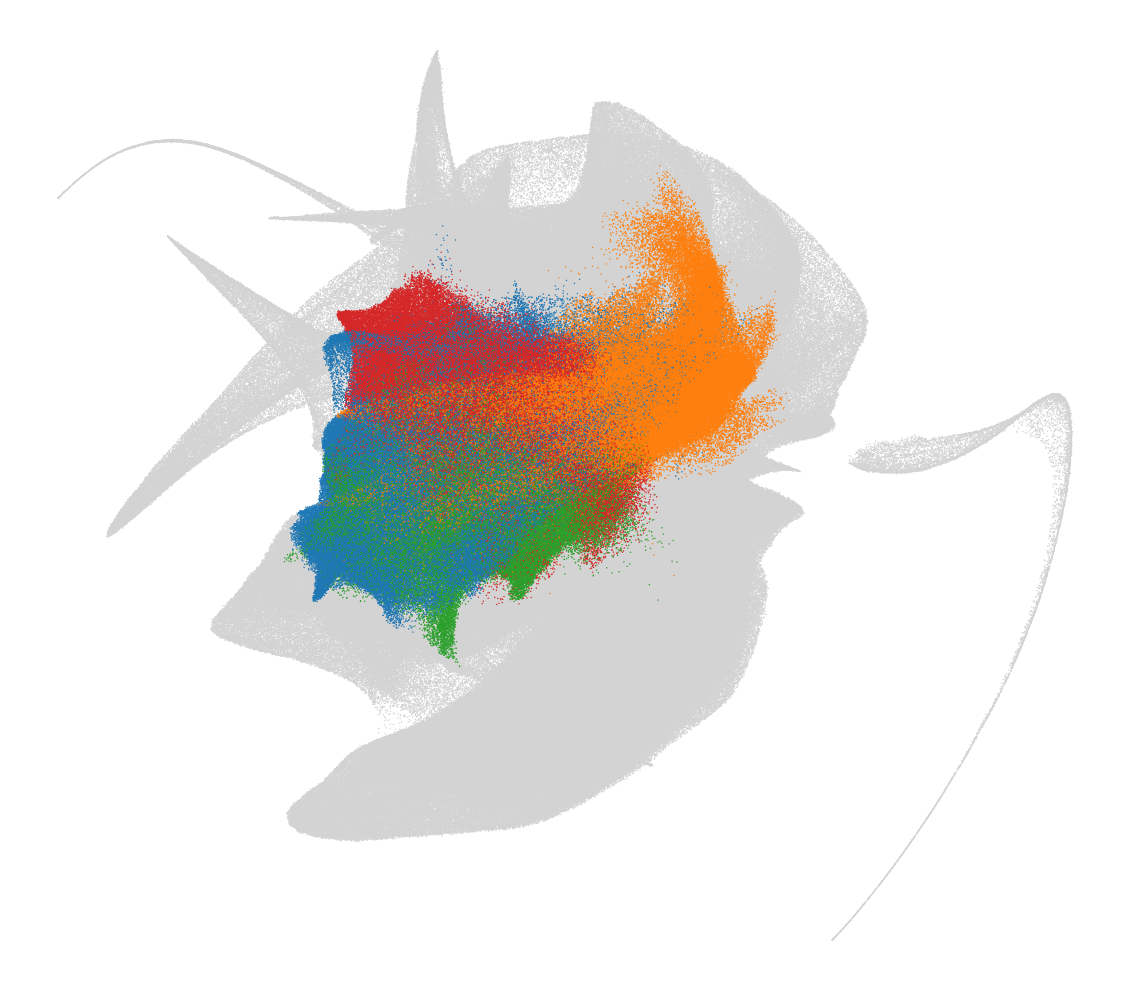

In [11]:
sns.set_context('paper', font_scale=3.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))

sc.pl.umap(adata_train, color='supercluster', show=False, ax=ax, size=8, groups=['Hot discohesive', 'Cold cohesive', 'Hot cohesive', 'Cold discohesive'], na_in_legend=False, legend_loc=None, cmap='Set2')
ax.set_title(None)
plt.axis('off')
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_feature_category_stroma_epi_ratio.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Hazard ratios

In [59]:
sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries/')
from data_processing import *

hazard_ratios = load_hazard_ratios(which='malignant')
hazard_ratios = hazard_ratios.rename(columns={'covariate':'HPC'})
hazard_ratios

HPC          coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
0   HPC 69 -9.143486e-02   0.912728  0.060699       -0.210477        0.027607   
1    HPC 0 -6.340027e-02   0.938595  0.035422       -0.132961        0.006160   
2   HPC 48 -3.259174e-02   0.967962  0.037511       -0.106142        0.040958   
3   HPC 61 -1.462880e-02   0.985505  0.049015       -0.110712        0.081455   
4   HPC 11 -1.302853e-02   0.987125  0.025089       -0.068028        0.041971   
5   HPC 34 -9.902549e-03   0.990241  0.027146       -0.069365        0.049560   
6   HPC 67 -1.217854e-03   0.998786  0.007250       -0.032635        0.030199   
7   HPC 50 -2.099341e-07   1.000000  0.000305       -0.000757        0.000756   
8   HPC 28  1.534842e-08   1.000000  0.000115       -0.000228        0.000228   
9   HPC 54  6.282187e-04   1.000632  0.014429       -0.043893        0.045149   
10  HPC 46  2.198451e-03   1.002206  0.015005       -0.043997        0.048394   
11  HPC 68  3.170078e-03   1.003194  0.007993       -0.031439        0.037779   
12  HPC 31  3.725590e-03   1.003742  0.016701       -0.047798        0.055249   
13  HPC 17  6.557245e-03   1.006609  0.024578       -0.047359        0.060474   
14  HPC 44  8.201078e-03   1.008301  0.017214       -0.044612        0.061014   
15  HPC 35  1.247194e-02   1.012601  0.029481       -0.052102        0.077046   
16  HPC 21  1.504599e-02   1.015275  0.021287       -0.038790        0.068882   
17  HPC 40  1.915399e-02   1.019403  0.034682       -0.056782        0.095090   
18   HPC 5  2.718688e-02   1.027624  0.032158       -0.035907        0.090280   
19  HPC 52  2.814598e-02   1.028712  0.031220       -0.033091        0.089383   
20  HPC 33  2.954631e-02   1.030034  0.029736       -0.028749        0.087842   
21  HPC 47  3.121266e-02   1.031890  0.025130       -0.023781        0.086206   
22  HPC 41  3.588948e-02   1.036697  0.035674       -0.034071        0.105850   
23  HPC 64  4.355629e-02   1.044593  0.048231       -0.050994        0.138106   
24  HPC 30  4.385998e-02   1.044867  0.032430       -0.019730        0.107450   
25  HPC 13  4.810925e-02   1.049330  0.036085       -0.022620        0.118839   
26  HPC 27  1.137569e-01   1.120559  0.040798        0.033752        0.193762   

    exp(coef) lower 95%  exp(coef) upper 95%         z             p  \
0              0.810411             1.027981 -1.499727  2.642909e-02   
1              0.875644             1.006090 -1.800771  2.956458e-03   
2              0.899348             1.041816 -0.871419  4.612673e-01   
3              0.895246             1.084868 -0.296521  9.871847e-01   
4              0.940197             1.037032 -0.418622  9.261412e-01   
5              0.939371             1.044608 -0.303271  9.704989e-01   
6              0.985140             1.013413 -0.033915  9.999995e-01   
7              0.999402             1.000598 -0.000591  1.000000e+00   
8              0.999774             1.000226  0.000171  1.000000e+00   
9              0.973278             1.029973  0.018307  9.999990e-01   
10             0.973683             1.032876  0.059825  9.999928e-01   
11             0.987875             1.019731  0.080822  9.999542e-01   
12             0.972008             1.038156  0.090252  9.999435e-01   
13             0.959488             1.056660  0.221880  9.922691e-01   
14             0.975254             1.044198  0.192985  9.970206e-01   
15             0.955989             1.073449  0.343157  9.696902e-01   
16             0.973922             1.059606  0.415850  9.238057e-01   
17             0.952649             1.092067  0.442063  9.263874e-01   
18             0.964865             1.094474  0.851462  4.603007e-01   
19             0.967691             1.093586  0.922619  2.945546e-01   
20             0.971713             1.091857  0.990539  3.034465e-01   
21             0.982214             1.084711  0.994626  2.299254e-01   
22             0.966718             1.111749  1.018820  2.345557e-01   
23        

In [60]:
adata_train.obs['HPC'] = adata_train.obs['leiden_2.5'].apply(lambda x: 'HPC ' + str(x))
adata_train.obs = adata_train.obs.merge(hazard_ratios[['HPC', 'exp(coef)']], on='HPC', how='left')
adata_train.obs = adata_train.obs.rename(columns={'exp(coef)':'malignant_hazard_ratio_exp'})
adata_train.obs

has_recurrence    hist_subtype  indexes labels   li male original_set  \
0                    1  tiled_images_5  4528043    0.0  0.0    1        train   
1                    1  tiled_images_5   810093    0.0  0.0    0        train   
2                    1  tiled_images_5   504174    0.0  0.0    1        train   
3                    1  tiled_images_5   149614    0.0  0.0    0        valid   
4                    1  tiled_images_5  2572634    0.0  1.0    1        train   
...                ...             ...      ...    ...  ...  ...          ...   
2499995              1  tiled_images_5  3715277    0.0  0.0    0        train   
2499996              1  tiled_images_5   671925    0.0  0.0    1        valid   
2499997              1  tiled_images_5  1292681    0.0  1.0    1        train   
2499998              1  tiled_images_5  3698670    0.0  0.0    0        train   
2499999              1  tiled_images_5   569990    0.0  0.0    0        train   

        os_event_data os_event_ind        patterns  ...   vi leiden_2.5  \
0         113.1616438            1  tiled_images_5  ...  0.0         63   
1         18.44383562            1  tiled_images_5  ...  1.0         56   
2         42.31232877            0  tiled_images_5  ...  0.0         16   
3         34.32328767            1  tiled_images_5  ...  0.0         34   
4         53.35890411            0  tiled_images_5  ...  0.0         70   
...               ...          ...             ...  ...  ...        ...   
2499995   38.59726027            0  tiled_images_5  ...  0.0         23   
2499996   0.295890411            1  tiled_images_5  ...  0.0         27   
2499997   53.35890411            0  tiled_images_5  ...  0.0         70   
2499998   77.22739726            1  tiled_images_5  ...  1.0         19   
2499999   52.43835616            0  tiled_images_5  ...  0.0         13   

                        consensus_feature contain_tumour stroma_epi_ratio  \
0                 Normal/near-normal lung              0              0.0   
1                            Collagenosis              0              0.0   
2                      Lymphocytic stroma              0      More stroma   
3                              Cribriform              1  More epithelium   
4        Non-neoplastic pathological lung              0              0.0   
...                                   ...            ...              ...   
2499995                         Elastosis              0              0.0   
2499996                            Acinar              1      More stroma   
2499997  Non-neoplastic pathological lung              0              0.0   
2499998           Normal/near-normal lung              0              0.0   
2499999                             Solid              1  More epithelium   

        stroma_cellularity inflammation       feature_category     HPC  \
0                      0.0     Moderate  Normal/non-neoplastic  HPC 63   
1                      0.0     Moderate                 Stroma  HPC 56   
2                 Moderate         High  Normal/non-neoplastic  HPC 16   
3                 Moderate     Moderate              Malignant  HPC 34   
4                      0.0     Moderate  Normal/non-neoplastic  HPC 70   
...                    ...          ...                    ...     ...   
2499995                0.0          Low                 Stroma  HPC 23   
2499996           Moderate          Low              Malignant  HPC 27   
2499997                0.0     Moderate  Normal/non-neoplastic  HPC 70   
2499998                0.0     Moderate  Normal/non-neoplastic  HPC 19   
2499999           Moderate     Moderate              Malignant  HPC 13   

        malignant_hazard_ratio_exp  
0                              NaN  
1                              NaN  
2                              NaN  
3                         0.990241  
4                              NaN  
...                            ...  
2499995                        NaN  
2499996                 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


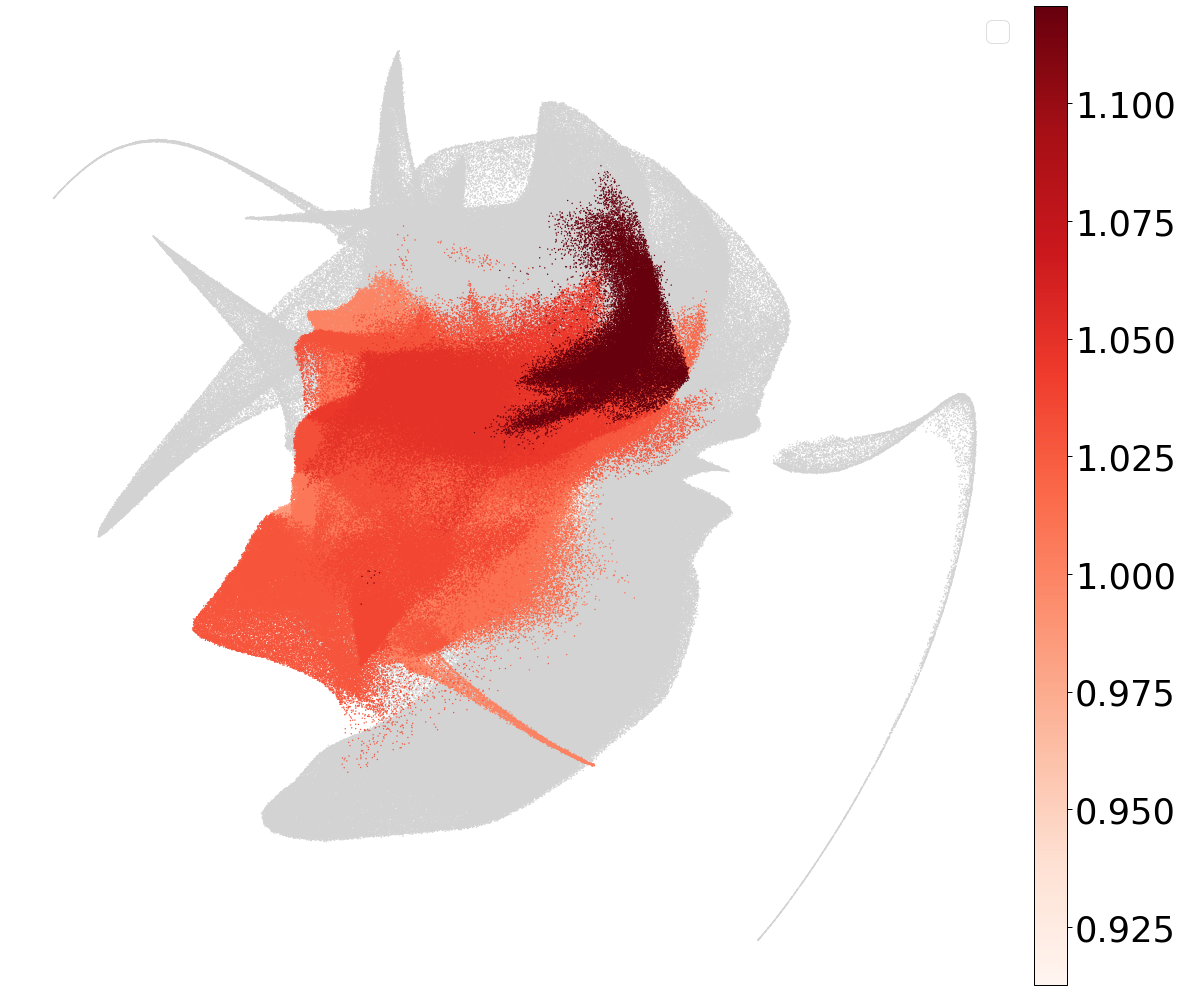

In [63]:
sns.set_context('paper', font_scale=4.0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,18))
# sns.set_theme(style='white')

sc.pl.umap(adata_train, color='malignant_hazard_ratio_exp', show=False, ax=ax, size=8, legend_loc='on data', groups=list(hazard_ratios['HPC']), cmap='Reds')
legend_c = ax.legend(loc='best', markerscale=1, prop={'size': 28});
legend_c.get_title().set_fontsize(15)
ax.set_title(None)
plt.axis('off')
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/tile_UMAPs/UMAP_clusters_hazard_ratio_tumour.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()